* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite 
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt
import copy 
from cobra.flux_analysis.loopless import loopless_solution


model_data=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")



Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [2]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] # 
growth_rates = [0.033713, 0.081992, 0.122398, 0.172112, 0.232267]


In [3]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 


In [4]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] # 
    growth_rates = [0.033713, 0.081992, 0.122398, 0.172112, 0.232267]
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective =  "ATPM" 
    model.reactions.BIOMASS_RT.bounds = growth_rates[i], growth_rates[i]
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])

    model.optimize('minimize') 
    solution = loopless_solution(model) # model.optimize('minimize') # 

        
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [5]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes, title): 
    threshold = 0.05 # threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective = "ATPM" 
    solution = model.optimize('minimize')   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
              
    fig = plt.figure()
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux) #, radius=1 textprops={'fontsize': 16} #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.legend()
    
    # plt.title(title)
    # plt.tight_layout()

    
    return pie_chart, fig

In [6]:
# import pickle

# with open("../cofactor_comparison/IFO0880_NGAM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)


In [7]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate
nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR


SUM produced: 0.602965574099064, SUM consumed: -0.602965574099064
SUM produced: 3.9747341678016617, SUM consumed: -3.974734167801662


,flux,reaction,percent
ALCD2y,3.558829,ALCD2y,0.895363
ALDD2ym,0.237211,ALDD2ym,0.059680
PYDXOR,0.164037,PYDXOR,0.041270
PPND2,0.014657,PPND2,0.003687
3NPHBH2_m,-0.000172,3NPHBH2_m,0.000043
COQ7_m,-0.000172,COQ7_m,0.000043
DPR,-0.000179,DPR,0.000045
HEMEASm,-0.000321,HEMEASm,0.000081
KYN3OX,-0.000391,KYN3OX,0.000098
DHFR,-0.001492,DHFR,0.000375


([<matplotlib.patches.Wedge at 0x1ea18031fd0>,
 [Text(1.0964520786564194, 0.08827705936435169, '5.1% Aldehyde dehydrogenase  acetylaldehyde  NADP   mitochondrial (0.03)'),
  Text(-0.014045935057167683, 1.0999103198481093, '90.6% Homoserine dehydrogenase (NADPH) (0.55)'),
  Text(-1.0974899033839898, 0.07426918587274993, '4.3% Other producing (0.03)'),
  Text(-1.0940657332332109, -0.11410596550959437, '6.6% Aspartate-semialdehyde dehydrogenase (-0.04)'),
  Text(-1.043502090525176, -0.3479991193517415, '7.3% Fatty acyl CoA synthase  n C80CoA   lumped reaction (-0.04)'),
  Text(-0.6200795701625117, -0.90857103556468, '34.1% Glutamate dehydrogenase (NADP) (-0.21)'),
  Text(0.10212253573793931, -1.0952492810746115, '9.9% Hydroxymethylglutaryl CoA reductase (-0.06)'),
  Text(0.3760651330361086, -1.0337190216468564, '6.4% Methylenetetrahydrofolate dehydrogenase (NADP) (-0.04)'),
  Text(0.6514951602453097, -0.8863148741711031, '11.8% NADPH transporter, endoplasmic reticulum (-0.07)'),
  Text(1.

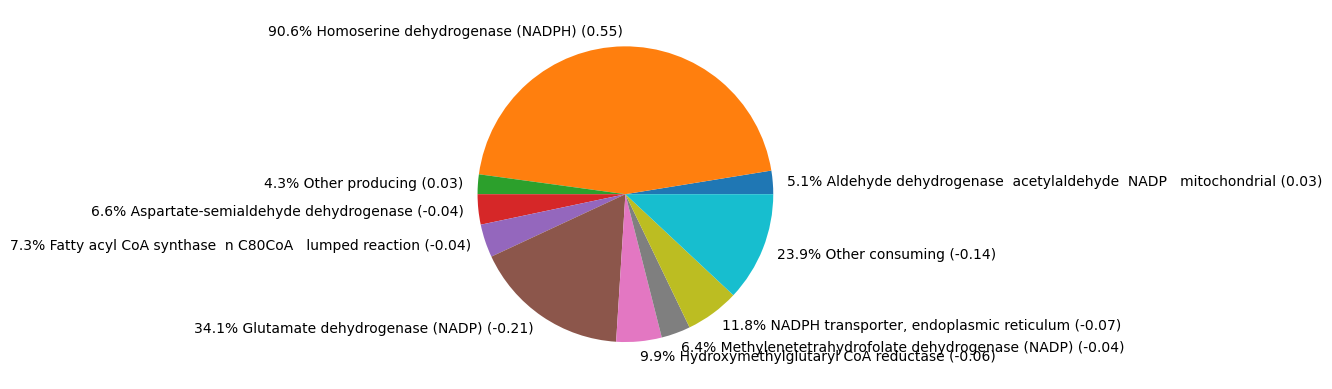

In [8]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

# fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\IFO0880_nm_NADPH.png")


([<matplotlib.patches.Wedge at 0x1ea1a11f980>,
 [Text(0.17998724681963552, 1.085174912621135, '89.5% Alcohol dehydrogenase (ethanol, NADP) (3.56)'),
  Text(-1.0697701636262997, 0.25610895535876904, '6.0% Aldehyde dehydrogenase  acetylaldehyde  NADP   mitochondrial (0.24)'),
  Text(-1.0972582605464716, 0.07761642649936869, '4.5% Other producing (0.18)'),
  Text(-1.0921942251251353, -0.13081198187973944, '7.6% Fatty acyl CoA synthase  n C80CoA   lumped reaction (-0.3)'),
  Text(-0.7827634439161701, -0.7728398222584658, '34.4% Glutamate dehydrogenase (NADP) (-1.37)'),
  Text(-0.0969665816208306, -1.0957177930693518, '10.4% Hydroxymethylglutaryl CoA reductase (-0.41)'),
  Text(0.19609766789486532, -1.0823796490354922, '6.7% Methylenetetrahydrofolate dehydrogenase (NADP) (-0.26)'),
  Text(0.5050754467001296, -0.97718923097866, '12.3% NADPH transporter, endoplasmic reticulum (-0.49)'),
  Text(0.9903660938500571, -0.47872225784078604, '28.7% Other consuming (-1.14)')])

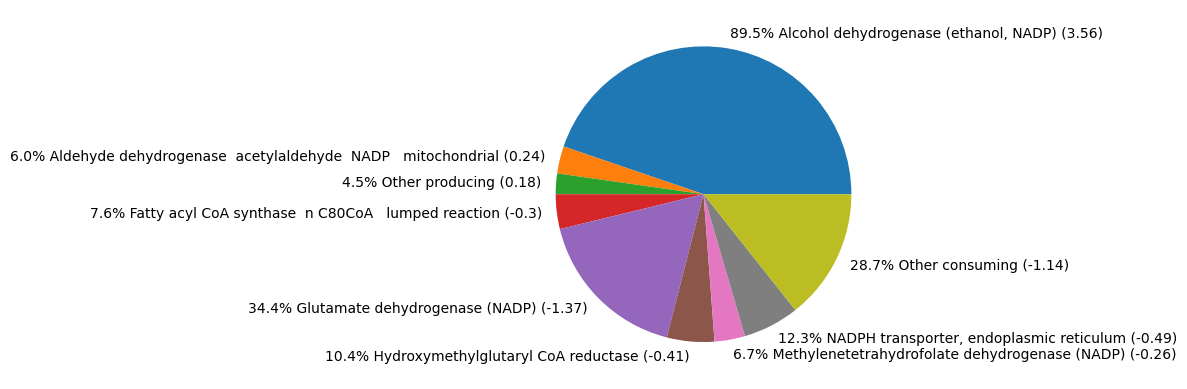

In [9]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

# fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\IFO0880_nm_NADPH_max.png")


In [10]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR


SUM produced: 2.275230061973038, SUM consumed: -2.275230061973038
SUM produced: 13.546989759579454, SUM consumed: -13.546989759579452


,flux,reaction,percent
GAPD,3.623685,GAPD,2.674901e-01
MDHm,2.610334,MDHm,1.926874e-01
PDHm,2.563157,PDHm,1.892049e-01
ICDHxm,2.256614,ICDHxm,1.665768e-01
AKGDm,2.048087,AKGDm,1.511839e-01
IPMD,0.074373,IPMD,5.490006e-03
MMSAD3m,0.042603,MMSAD3m,3.144802e-03
3HPDm,0.042603,3HPDm,3.144802e-03
HICITDm,0.040028,HICITDm,2.954716e-03
SACCD2,0.040028,SACCD2,2.954716e-03


In [11]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart


TypeError: cofactor_fluxes_pie_chart() takes 2 positional arguments but 3 were given

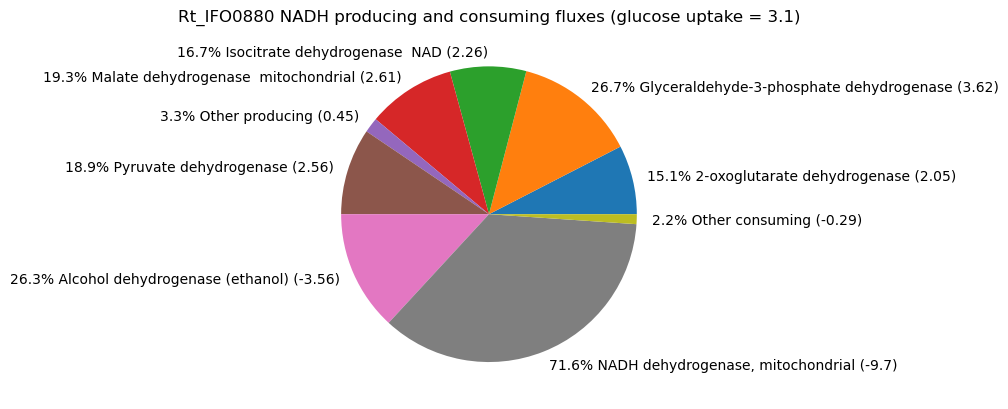

([<matplotlib.patches.Wedge at 0x1ec9735a450>,
 [Text(1.0691275184763762, 0.25877857182646674, '15.1% 2-oxoglutarate dehydrogenase (2.05)'),
  Text(0.6879585712459085, 0.8583198729199321, '26.7% Glyceraldehyde-3-phosphate dehydrogenase (3.62)'),
  Text(-0.006781347740635115, 1.099979096766307, '16.7% Isocitrate dehydrogenase  NAD (2.26)'),
  Text(-0.5940542732783167, 0.9257966949604924, '19.3% Malate dehydrogenase  mitochondrial (2.61)'),
  Text(-0.878337159227349, 0.6622113218002473, '3.3% Other producing (0.45)'),
  Text(-1.0517754505514578, 0.32213103175148816, '18.9% Pyruvate dehydrogenase (2.56)'),
  Text(-1.0076664544660352, -0.44114432620611793, '26.3% Alcohol dehydrogenase (ethanol) (-3.56)'),
  Text(0.40682234264080647, -1.022005666094003, '71.6% NADH dehydrogenase, mitochondrial (-9.7)'),
  Text(1.0993710858785561, -0.03719160569542849, '2.2% Other consuming (-0.29)')])

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart

In [ ]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

SUM produced: 8.054414544347754, SUM consumed: -8.054414544347749
SUM produced: 47.53277681570152, SUM consumed: -47.53277681570161


,flux,reaction,percent
ATPS3m,37.076675,ATPS3m,0.780023
PGK,3.623685,PGK,0.076235
PYK,3.536738,PYK,0.074406
SUCOASm,2.046803,SUCOASm,0.043061
ACKr,1.247295,ACKr,0.026241
...,...,...,...
ACS,-1.270577,ACS,0.026731
PFK,-1.413706,PFK,0.029742
ADK1,-2.757374,ADK1,0.058010
HEX1,-3.100000,HEX1,0.065218


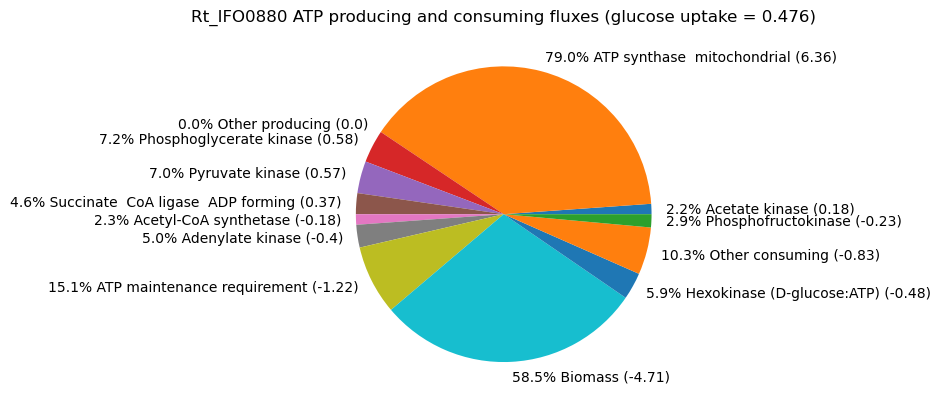

([<matplotlib.patches.Wedge at 0x1eca6ec25a0>,
 [Text(1.0993144368860086, 0.03882999940764703, '2.2% Acetate kinase (0.18)'),
  Text(0.28227674613441406, 1.0631650100486603, '79.0% ATP synthase  mitochondrial (6.36)'),
  Text(-0.9142752241427439, 0.6116378131858228, '0.0% Other producing (0.0)'),
  Text(-0.9773005737135215, 0.5048599693174552, '7.2% Phosphoglycerate kinase (0.58)'),
  Text(-1.064755783387608, 0.27621571595881594, '7.0% Pyruvate kinase (0.57)'),
  Text(-1.0971678416020192, 0.07888426556904043, '4.6% Succinate  CoA ligase  ADP forming (0.37)'),
  Text(-1.0992886039442016, -0.03955458555475635, '2.3% Acetyl-CoA synthetase (-0.18)'),
  Text(-1.0876504568797605, -0.16436691774578252, '5.0% Adenylate kinase (-0.4)'),
  Text(-0.9827257360061289, -0.4942166810127037, '15.1% ATP maintenance requirement (-1.22)'),
  Text(0.0566548835852605, -1.0985400421313465, '58.5% Biomass (-4.71)'),
  Text(0.9610850210033042, -0.5350846497546706, '5.9% Hexokinase (D-glucose:ATP) (-0.48)'),
 

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

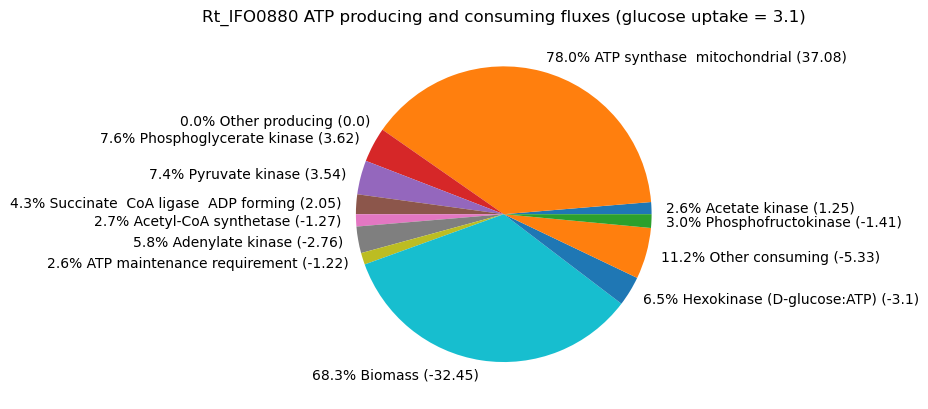

([<matplotlib.patches.Wedge at 0x1ec97badc40>,
 [Text(1.0990656859863313, 0.045327893039442374, '2.6% Acetate kinase (1.25)'),
  Text(0.28608352783256463, 1.0621469837564264, '78.0% ATP synthase  mitochondrial (37.08)'),
  Text(-0.9025022503914191, 0.6288797087189445, '0.0% Other producing (0.0)'),
  Text(-0.9711947198576397, 0.5165082924025916, '7.6% Phosphoglycerate kinase (3.62)'),
  Text(-1.0652142151548547, 0.27444248182820985, '7.4% Pyruvate kinase (3.54)'),
  Text(-1.0974846281048147, 0.0743470986228553, '4.3% Succinate  CoA ligase  ADP forming (2.05)'),
  Text(-1.0990304846383827, -0.04617351876911386, '2.7% Acetyl-CoA synthetase (-1.27)'),
  Text(-1.0831803593757914, -0.1916254394972953, '5.8% Adenylate kinase (-2.76)'),
  Text(-1.0487205442917422, -0.3319415912181423, '2.6% ATP maintenance requirement (-1.22)'),
  Text(-0.16626358524536716, -1.087362138489913, '68.3% Biomass (-32.45)'),
  Text(0.9389921025233288, -0.5729693110445084, '6.5% Hexokinase (D-glucose:ATP) (-3.1)'),

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_results\\Glucose_maximization\\IFO0880_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(growth_rates[5], 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(growth_rates[5], 2)}', index=False)
#     atps_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(growth_rates[0], 2)}', index=False)
#     atps_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(growth_rates[5], 2)}', index=False)

    